In [1]:
import torchvision
from torchvision.utils import draw_bounding_boxes
from torchvision.io import decode_image
import torchvision.transforms.functional as F
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

In [3]:
vidcap = cv2.VideoCapture("input/football.mp4")
success, image = vidcap.read()
count = 0
while success:
    cv2.imwrite("frames/frame%d.jpg" % count, image)  # save frame as JPEG file
    success, image = vidcap.read()
    count += 1

In [2]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [3]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
import os
import glob

imgs = [
    decode_image(file)
    for file in sorted(glob.glob(os.getcwd() + "/frames/*"), key=os.path.getmtime)
]

In [24]:
import torchvision.transforms as T

score_threshold = 0.55
count = 0

for img in imgs:
    timg = [transforms(img)]
    prediction = model(timg)

    output = draw_bounding_boxes(
        img,
        boxes=prediction[0]["boxes"][prediction[0]["scores"] > score_threshold],
        colors='orange',
        width=5,
    )

    tans = T.ToPILImage()
    test = tans(output)
    test.save("outputs/out%d.jpg" % count)
    count += 1

**Region Proposal Network (RPN)**

The region proposal network is the first main part of the Faster RCNN model. This network is responsible for proposing interesting regions within an input image. It does so by first taking an image and passing it through a CNN, then using a sliding window approach on the feature map returned by that CNN. We end up with multiple regions inside the window, and for each region we will create multiple predictions, or anchor boxes centered in that region.

These anchor boxes are of varying widths and heights (but still centered). This allows use to more accurately predict objects that don't fit neatly in a square. Now we predict if there is an object inside each anchor box. Using these predictions, we will be able to get the general shape of objects inside the image. It won't be amazingly accurate or precise, but that's fine.

For each window, we make a forward pass and get 1 by 1 convolutions that generate scores for each location, as well as transformation predictions for each location. This transformation prediction predicts how the box shape has to be transformed to better fit the contained object (if there is one).

An example of proposals
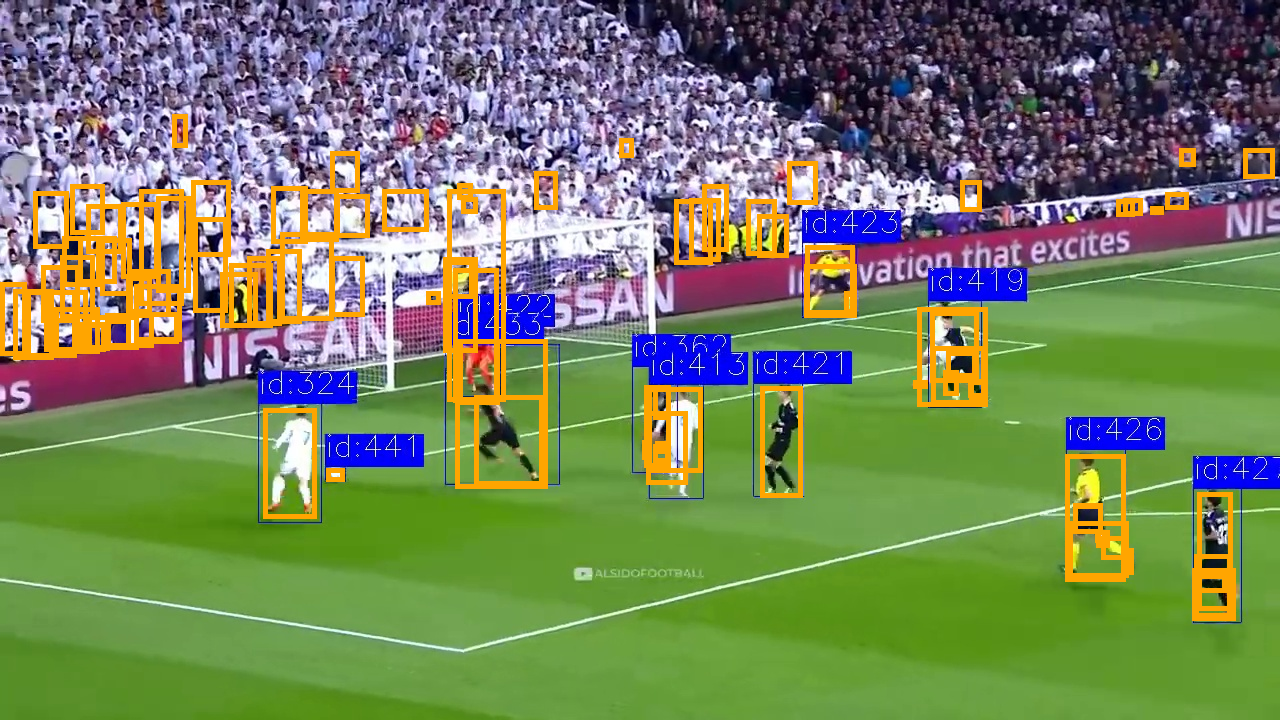
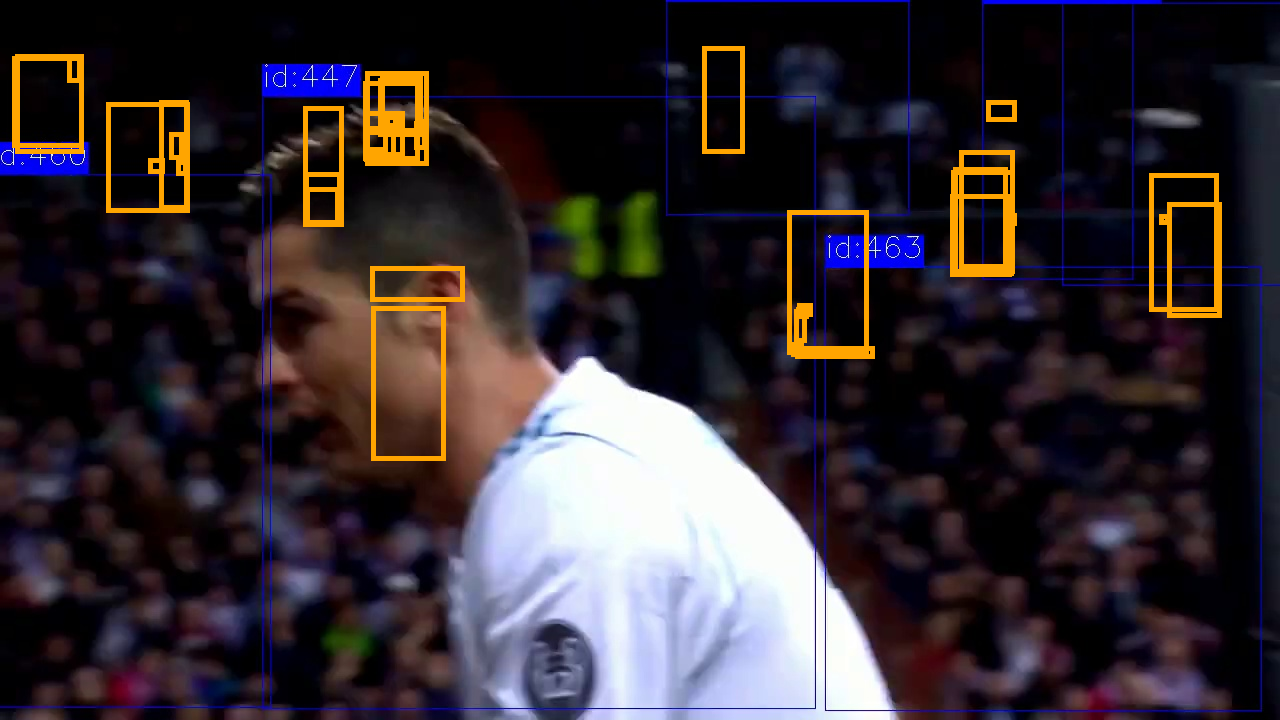

**Training**

Once the RPN has propsed many regions, it's time to classify the objects contained within them. The proposed anchor boxes are compared against the ground truths, and are split into two categories: if the anchor box has high overlap with the ground truth, it is labeled a 'foreground' box, and if it has very low overlap it is labeld 'background'. This divides the proposals into ones that closely outline an object and ones that do not outline anything at all. This means that proposals that only have mediocre overlap are ignored.

Using these new proposals, the model can determine the loss between the proposed regions and the ground truths. Proposals that are similar to the 'background' are punished, and proposals similar to the 'foreground' are rewarded.

**Output**

Now that the model is trained, we can simply pass in an image and get the proposed regions. These proposed regions will have varying conidence levels, and not all of them will be very good, so it's usually best to filter the proposals by some confidence level, like so.

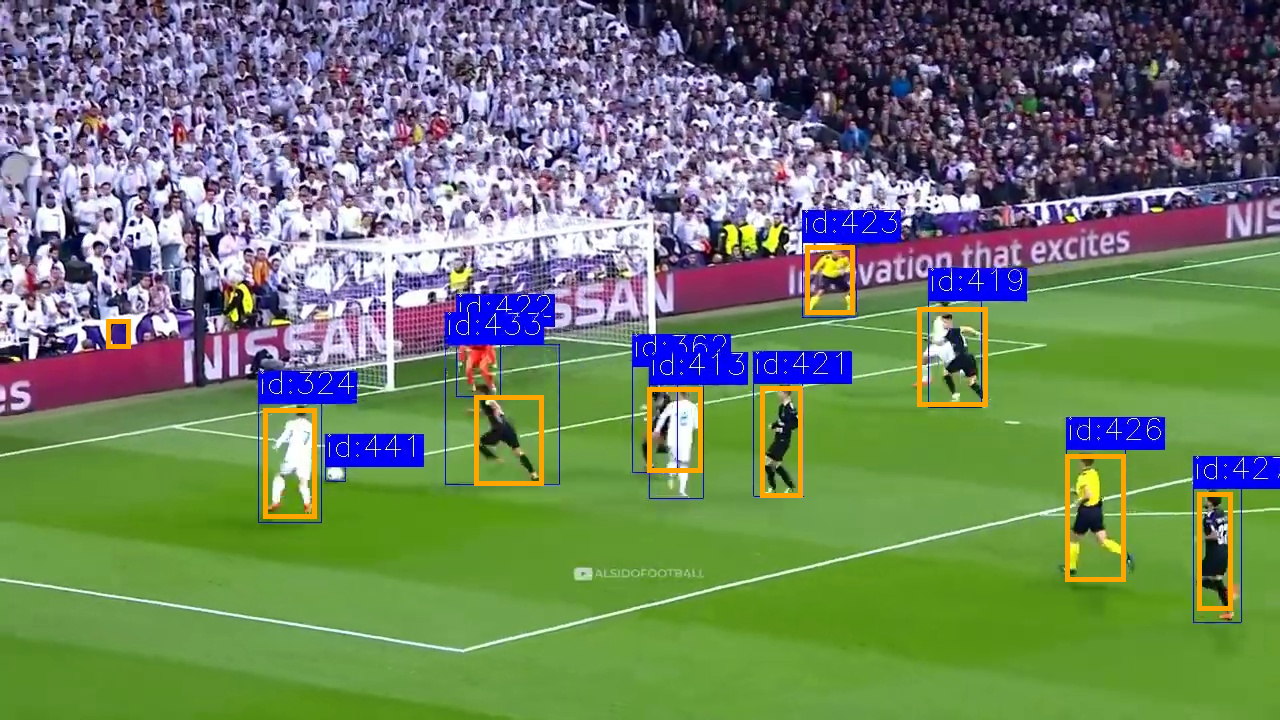